In [6]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [7]:
data = {
    "spectro_cols": [
        "h_alpha_flux", "oiii_5007_flux", "nii_6584_flux", "sii_6717_flux",
        "lick_mgb", "lick_fe5335", "d4000", "velocityDisp"
    ],
    "photometry_cols": [
        "modelMag_u", "modelMag_r", "modelMag_z", "fracDev_r", "petroRad_r",
        "extinction_u", "extinction_r", "extinction_z"
    ],
    "generic_cols": ["z", "zErr"],
    "target_col": ["logM_star"]
}
    
spectro_cols = data['spectro_cols']
photo_cols = data['photometry_cols']
generic_cols = data['generic_cols']
target_col = data['target_col']

In [8]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Input shape
input_shape = X_train_scaled.shape[1]
optimizer = Adam(learning_rate=0.001)

# Input layer
inputs = keras.Input(shape=(input_shape,), name='Input')

# 🔄 Projection layer to align reduced input space
x = layers.Dense(128, activation='relu', name='Projection')(inputs)

# Layer 1 (frozen)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(x)
x = layers.Dropout(0.1, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2 (partially unfrozen)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.1, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3 (trainable)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_new')(x)
x = layers.Dropout(0.1, name='Dropout_128_new')(x)
x = layers.BatchNormalization(name='BatchNorm_128_new')(x)
x = layers.Activation('relu', name='Activation_128_new')(x)

# 🔁 Residual connection with projection
shortcut = x  # shape (128,)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_new')(x)
x = layers.Dropout(0.1, name='Dropout_64_new')(x)
x = layers.BatchNormalization(name='BatchNorm_64_new')(x)
x = layers.Activation('relu', name='Activation_64_new')(x)

# Project shortcut to match shape
shortcut_proj = layers.Dense(64, name='Shortcut_Projection')(shortcut)
x = layers.Add(name='Residual_Add')([x, shortcut_proj])

# Layer 5 (trainable)
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32_new')(x)
x = layers.Dropout(0.1, name='Dropout_32_new')(x)
x = layers.BatchNormalization(name='BatchNorm_32_new')(x)
x = layers.Activation('relu', name='Activation_32_new')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs, name='Photo_Transfer_Learned_Regression_Model')

# Load weights from base model
model.load_weights('models/spectro_photo_base_regression_model.h5', by_name=True, skip_mismatch=True)

# Freeze reused layers
model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = True  # Allow adaptation

# Compile with Huber loss
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
loss = tf.keras.losses.Huber(delta=1.0)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['mae', 'mse', 'mape'])

# Summary
model.summary()

Model: "Photo_Transfer_Learned_Regression_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 Projection (Dense)             (None, 128)          1408        ['Input[0][0]']                  
                                                                                                  
 Dense_64 (Dense)               (None, 64)           8256        ['Projection[0][0]']             
                                                                                                  
 Dropout_64 (Dropout)           (None, 64)           0           ['Dense_64[0][0]']               
                                                            

In [11]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
2922/2922 [==============================] - 33s 11ms/step - loss: 5.9906 - mae: 1.3021 - mse: 5.6731 - mape: 12.2017 - val_loss: 0.3059 - val_mae: 0.1439 - val_mse: 0.0393 - val_mape: 1.3513
Epoch 2/200
2922/2922 [==============================] - 28s 10ms/step - loss: 0.4795 - mae: 0.3744 - mse: 0.2696 - mape: 3.5398 - val_loss: 0.2181 - val_mae: 0.1701 - val_mse: 0.0531 - val_mape: 1.5900
Epoch 3/200
2922/2922 [==============================] - 23s 8ms/step - loss: 0.3381 - mae: 0.3027 - mse: 0.1914 - mape: 2.8774 - val_loss: 0.1726 - val_mae: 0.1250 - val_mse: 0.0375 - val_mape: 1.1894
Epoch 4/200
2922/2922 [==============================] - 24s 8ms/step - loss: 0.2767 - mae: 0.2645 - mse: 0.1478 - mape: 2.5211 - val_loss: 0.1435 - val_mae: 0.1014 - val_mse: 0.0214 - val_mape: 0.9669
Epoch 5/200
2922/2922 [==============================] - 25s 8ms/step - loss: 0.2245 - mae: 0.2254 - mse: 0.1075 - mape: 2.1499 - val_loss: 0.1365 - val_mae: 0.1074 - val_mse: 0.0256 - val_

In [12]:
def plot_metrics(y_test, y_pred, threshold=0.2):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Dex accuracy metrics (since inputs are already in log space)
    mae_dex = mae  # identical unless you're converting from linear scale
    rmse_dex = rmse

    # Fraction of predictions within ±threshold dex
    within_tolerance = np.mean(np.abs(y_pred - y_test) <= threshold)

    print(f"📊 Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae_dex:.4f} dex")
    print(f"Root Mean Squared Error (RMSE): {rmse_dex:.4f} dex")
    print(f"R² Score: {r2:.4f}")
    print(f"Fraction within ±{threshold:.2f} dex: {within_tolerance:.2%}")

In [13]:
y_pred = model.predict(X_test_scaled)

1566/1566 [==============================] - 4s 3ms/step


In [14]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0497 dex
Root Mean Squared Error (RMSE): 0.0835 dex
R² Score: 0.9711
Fraction within ±0.20 dex: 96.96%


In [15]:
def plot_visualizations(y_test, y_pred, z_values=None, history=None):
    y_pred_flat = y_pred.ravel() if y_pred.ndim > 1 else y_pred

    if hasattr(y_test, 'iloc') and isinstance(y_test, pd.DataFrame):
        y_test_array = y_test.iloc[:, 0].values
    else:
        y_test_array = np.array(y_test)

    y_test_flat = y_test_array.ravel() if y_test_array.ndim > 1 else y_test_array
    residuals = y_test_flat - y_pred_flat

    # Residual Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_pred_flat,
            residuals,
            c=z_values,
            cmap='viridis',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot (Colored by Redshift)" if z_values is not None else "Residual Plot")
    plt.tight_layout()
    plt.show()

    # Parity Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_test_flat,
            y_pred_flat,
            c=z_values,
            cmap='plasma',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Parity Plot (Colored by Redshift)" if z_values is not None else "Parity Plot")
    plt.tight_layout()
    plt.show()

    # Residual Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Distribution of Prediction Errors")
    plt.tight_layout()
    plt.show()

    if history is not None:
        # Determine if history is a dictionary or a Keras History object
        _history = None
        if isinstance(history, dict):
            _history = history
        elif hasattr(history, 'history'):
            _history = history.history
        else:
            raise ValueError("Invalid history object provided. It should be a dictionary or a Keras History object.")
        
        # Training vs Validation Loss
        plt.figure(figsize=(8, 4))
        plt.plot(_history['loss'], label='Training Loss', color='steelblue')
        plt.plot(_history['val_loss'], label='Validation Loss', color='salmon')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Training vs Validation MAE
        plt.figure(figsize=(8, 4))
        plt.plot(_history['mae'], label='Training MAE', color='darkgreen')
        plt.plot(_history['val_mae'], label='Validation MAE', color='orange')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error")
        plt.title("Training vs Validation MAE")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

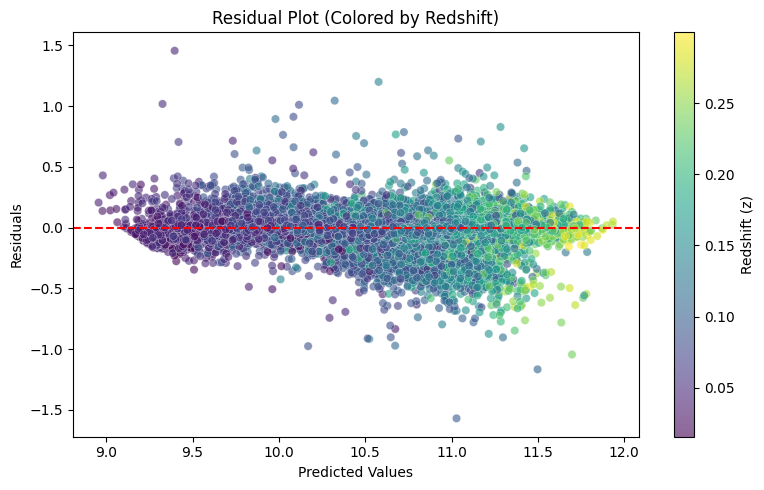

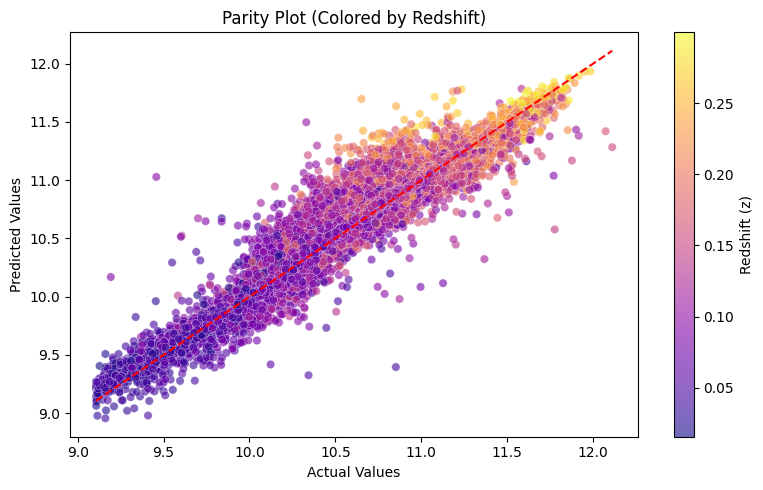

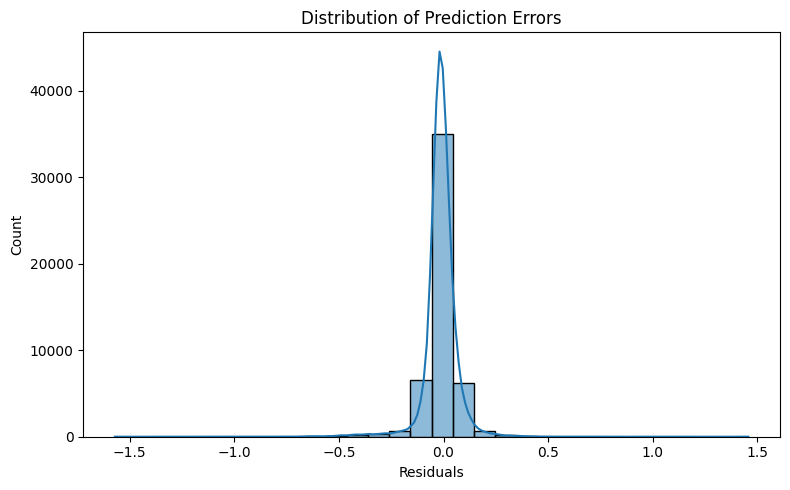

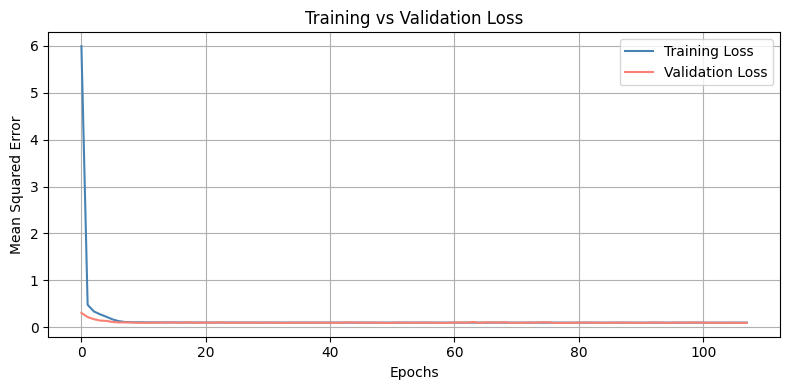

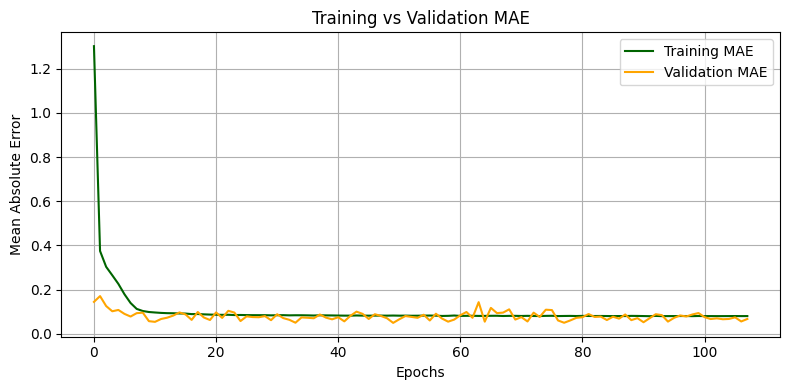

In [16]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

In [ ]:
X = df[spectro_cols + photo_cols + generic_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1 (frozen)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2 (frozen)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3 (trainable)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)
x = layers.BatchNormalization(name='BatchNorm_128_2')(x)
x = layers.Activation('relu', name='Activation_128_2')(x)

# Layer 4 (trainable)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)
x = layers.BatchNormalization(name='BatchNorm_64_2')(x)
x = layers.Activation('relu', name='Activation_64_2')(x)

# Layer 5 (trainable)
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32_2')(x)
x = layers.Dropout(0.2, name='Dropout_32_2')(x)
x = layers.BatchNormalization(name='BatchNorm_32_2')(x)
x = layers.Activation('relu', name='Activation_32_2')(x)

# Output
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Photo_No_Transfer_Learning_Regression_Model')

# Compile
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()
